# ALBERT Model applied to the **Spooky Author Classification** competition on **Kaggle**

- A more complete description of the Kaggle competition and dataset is available in the following link **https://www.kaggle.com/c/spooky-author-identification**
- The goal of this notebook is to apply an ALBERT model to the competition dataset, I could apply it to a more simple dataset like the Yelp Comments, IMDB reviews or the 20newsgroup dataset, however, as a Machine Learning exercise and because I want to improve my skills in the Tensorflow library, I decided to use this dataset
- The key reference for this notebook is available in the official TF Documentation **https://www.tensorflow.org/tutorials/text/classify_text_with_bert**
<br><br>

**Note:** English is not my primary language, my apologies in advance for any grammar mistake or typo<br>
Developed by jhonnatan.torres.suarez@gmail.com

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c spooky-author-identification

  0% 0.00/29.4k [00:00<?, ?B/s]
100% 29.4k/29.4k [00:00<00:00, 26.9MB/s]
  0% 0.00/538k [00:00<?, ?B/s]
100% 538k/538k [00:00<00:00, 74.8MB/s]
  0% 0.00/1.26M [00:00<?, ?B/s]
100% 1.26M/1.26M [00:00<00:00, 85.6MB/s]


In [ ]:
!ls
!pwd

kaggle.json  sample_data  sample_submission.zip  test.zip  train.zip
/content


In [ ]:
df = pd.read_csv('/content/train.zip')

In [ ]:
df.drop(columns='id', inplace=True)

In [ ]:
df.head(2)

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL


In [ ]:
df['text'] = df['text'].str.lower()

In [ ]:
df.head(2)

,text,author
0,"this process, however, afforded me no means of...",EAP
1,it never once occurred to me that the fumbling...,HPL


In [ ]:
df.author.value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [ ]:
authors_dict = {'EAP' : 0,
                'MWS' : 1,
                'HPL' : 2}

In [ ]:
df['author'] = df['author'].map(authors_dict)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import log_loss, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['author'], test_size=0.30, 
                                                    stratify=df['author'], random_state=1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13705,) (5874,) (13705,) (5874,)


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=2, max_features=5000, lowercase=False, stop_words=None)
scaler = MaxAbsScaler()
classifier = BernoulliNB(binarize=0, alpha=1)

In [ ]:
pl = make_pipeline(vectorizer, classifier)

In [ ]:
pl.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=False, max_df=1.0, max_features=5000,
                                 min_df=2, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('bernoullinb',
                 BernoulliNB(alpha=1, binarize=0, class_prior=None,
                             fit_prior=True))],
         ver

In [ ]:
preds_prob = pl.predict_proba(X_test)
preds_class = pl.predict(X_test)

In [ ]:
nb_loss = log_loss(y_test, preds_prob)
print(nb_loss)

0.530227192681336


In [ ]:
print(confusion_matrix(y_test, preds_class))
print('\n')
print(classification_report(y_test, preds_class))

[[2058  178  134]
 [ 288 1435   90]
 [ 310   82 1299]]


              precision    recall  f1-score   support

           0       0.77      0.87      0.82      2370
           1       0.85      0.79      0.82      1813
           2       0.85      0.77      0.81      1691

    accuracy                           0.82      5874
   macro avg       0.82      0.81      0.82      5874
weighted avg       0.82      0.82      0.82      5874



These metrics can be used as a baseline, a pretty simple **Naive Bayes** model was fitted and achieved an accuracy of around **81%**, not bad for a very simple model

In [ ]:
#This is a key step, you have to specify the version in order to avoid the Kaggle's kernel to upgrade tensorflow 
#and another dependencies that generate an error when Tensorflow tries to recognize the GPU
#!pip install tensorflow_text==2.3
!pip install tensorflow_text ## In Google Colab is not required to provide the required version

     |████████████████████████████████| 3.4MB 12.2MB/s 


In [ ]:
import tensorflow
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
tensorflow.random.set_seed(1234)
np.random.seed(1234)
import random
random.seed(1234)

In [ ]:
#extracted from the Tensorflow Hub
URL_PREPROCESSOR = "http://tfhub.dev/tensorflow/albert_en_preprocess/2"
URL_ENCODER = "https://tfhub.dev/tensorflow/albert_en_base/2"

In [ ]:
#Adjusted model based on the example explained in the official documentation available in the following link: 
#https://www.tensorflow.org/tutorials/text/classify_text_with_bert
def build_classifier_model():
    text_input = tensorflow.keras.layers.Input(shape=(), dtype=tensorflow.string, name='text')
    preprocessing_layer = hub.KerasLayer(URL_PREPROCESSOR, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(URL_ENCODER, trainable=True, name='ALBERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tensorflow.keras.layers.Dropout(0.50)(net)
    net = tensorflow.keras.layers.Dense(3, activation='softmax', name='classifier_b')(net)
    return tensorflow.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
!pip install -q tf-models-official

     |████████████████████████████████| 849kB 16.4MB/s 
     |████████████████████████████████| 36.7MB 86kB/s 
     |████████████████████████████████| 1.1MB 52.1MB/s 
     |████████████████████████████████| 102kB 15.8MB/s 
     |████████████████████████████████| 358kB 58.8MB/s 
     |████████████████████████████████| 174kB 65.6MB/s 


In [ ]:
from official.nlp import optimization  # to create AdamW optmizer

In [ ]:
train_tf, test_tf = train_test_split(df, test_size=0.30, stratify=df['author'], random_state=1234)
print(train_tf.shape, test_tf.shape)

(13705, 2) (5874, 2)


In [ ]:
#Utility referenced in the TF documentation to "transform" the pandas dataframe to a TF Tensor
#https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers#create_an_input_pipeline_using_tfdata
def df_to_dataset(dataframe, batch_size=32, target='author'):
    dataframe = dataframe.copy()
    labels = dataframe.pop(target)
    ds = tensorflow.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.batch(batch_size)
    return ds

In [ ]:
train_ds = df_to_dataset(train_tf, batch_size=32)

In [ ]:
test_ds = df_to_dataset(test_tf, batch_size=32)

In [ ]:
#Optimizer referenced in the documentation example
epochs = 5
steps_per_epoch = tensorflow.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

In [ ]:
#to check the TF version and the GPU used in the training process
import tensorflow
print(tensorflow.__version__)
tensorflow.test.gpu_device_name()

2.4.0


'/device:GPU:0'

In [ ]:
EPOCHS=2
with tensorflow.device('/device:GPU:0'):
    history = classifier_model.fit(x=train_ds, validation_data=test_ds, batch_size=32, epochs=EPOCHS)

Epoch 1/2
429/429 [==============================] - 553s 1s/step - loss: 1.0756 - accuracy: 0.5123 - val_loss: 0.4926 - val_accuracy: 0.8064
Epoch 2/2
429/429 [==============================] - 545s 1s/step - loss: 0.5447 - accuracy: 0.7893 - val_loss: 0.4615 - val_accuracy: 0.8291


In [ ]:
classifier_model.evaluate(train_ds, batch_size=32)

429/429 [==============================] - 147s 342ms/step - loss: 0.2624 - accuracy: 0.9007


[0.26244640350341797, 0.9006931781768799]

In [ ]:
classifier_model.evaluate(test_ds, batch_size=32)

184/184 [==============================] - 62s 339ms/step - loss: 0.4615 - accuracy: 0.8291


[0.4614786207675934, 0.8290773034095764]

In [ ]:
tf_preds = classifier_model.predict(test_ds)

In [ ]:
albert_loss = log_loss(y_test, tf_preds)
print(albert_loss)

0.4614784991540173


In [ ]:
#Multiclass Loss or Log Loss (sklearn) is the metric defined by Kaggle for this competition
diff_loss = nb_loss - albert_loss
if albert_loss < nb_loss:
    print("ALBERT improved the loss metric by {}".format(diff_loss))
else: print("loss metric was not improved by ALBERT compared to the base NB model")

ALBERT improved the loss metric by 0.06874869352731872


In [ ]:
tf_preds[0:5], y_test.iloc[0:5]

(array([[0.00252756, 0.00108689, 0.9963856 ],
        [0.64779645, 0.00709284, 0.34511068],
        [0.01092714, 0.9655519 , 0.02352085],
        [0.10766204, 0.34792036, 0.5444176 ],
        [0.9181267 , 0.0457281 , 0.03614512]], dtype=float32), 8659     2
 12432    0
 2051     1
 3344     2
 16796    2
 Name: author, dtype: int64)

In [ ]:
import numpy as np
tf_preds_class = np.argmax(tf_preds, axis=1)

In [ ]:
print(confusion_matrix(y_test, tf_preds_class))
print('\n')
print(classification_report(y_test, tf_preds_class))

[[2193   93   84]
 [ 392 1353   68]
 [ 317   50 1324]]


              precision    recall  f1-score   support

           0       0.76      0.93      0.83      2370
           1       0.90      0.75      0.82      1813
           2       0.90      0.78      0.84      1691

    accuracy                           0.83      5874
   macro avg       0.85      0.82      0.83      5874
weighted avg       0.84      0.83      0.83      5874



In [ ]:
dep = pd.read_csv('/content/test.zip')

In [ ]:
dep.head(2)

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."


In [ ]:
dep['text'] = dep['text'].str.lower()

In [ ]:
dep_preds = classifier_model.predict(dep['text'].values)
dep_df = pd.DataFrame(data=dep_preds, columns=['EAP','MWS','HPL'])

In [ ]:
submit_df = pd.concat([dep,dep_df], axis='columns')
submit_df.drop(columns='text', inplace=True)
submit_df.to_csv('submit.csv', index=False, index_label=False)

In [ ]:
submit_df.head(2)

,id,EAP,MWS,HPL
0,id02310,0.029809,0.962175,0.008016
1,id24541,0.995124,0.002497,0.002379


In [ ]:
files.download('/content/submit.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

As of December 2020, the model scored a log loss of **0.4675** on Kaggle, in our notebook the log loss score was **0.4614**, with just a couple of epochs, it was possible to decrease the loss metric by **0.07**

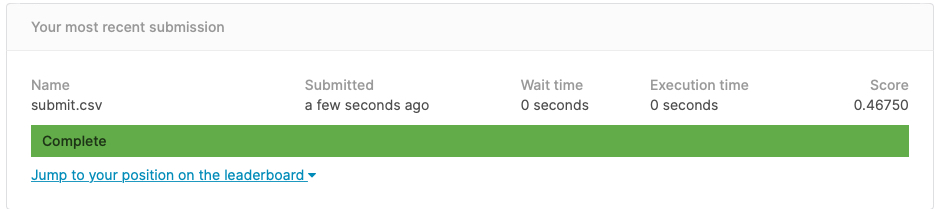

### Final Notes:
- I know a GPU should not be used for the inference stage, however, I wanted to keep the example in one single notebook

- An ALBERT (A Light BERT Model) was applied to this dataset based on an example provided in the official TF documentation, same optimizer was used, however, base model was changed and an additional utility was used in order to transform the pandas dataframe to a TF tensor.

- This is an example about how the different transformers available in the TF Hub can be used in a Text Classification Task.